# Estimation with SPDE

This document aims at demonstrating the use of SPDE for performing Estimation. It is based on Scotland Data

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
return false;
}

<IPython.core.display.Javascript object>

In [2]:
import gstlearn as gl
import matplotlib.pyplot as plt
import gstlearn.plot as gp
import os 
import numpy as np
import urllib.request

flagInternetAvailable = True

Getting the Data Bases from the official website.

In [3]:
fileNF='Scotland_Temperatures.NF'
if flagInternetAvailable:
    temp_nf, head = urllib.request.urlretrieve('https://soft.minesparis.psl.eu/gstlearn/data/Scotland/'+fileNF,'./'+fileNF)
else:
    temp_nf='./'+fileNF
dat = gl.Db.createFromNF(temp_nf)

The input Data Base (called **temperatures**) contains the target variable (**January_temp**). Note that this data base also contains the elevation variable (called **Elevation**) which is assigned the locator **f** (for external drift). We finally add a selection (called **sel**) which only consider the samples where the temperature is actually calculated.


Data Base Characteristics

Data Base Summary
-----------------
File is organized as a set of isolated points
Space dimension              = 2
Number of Columns            = 6
Maximum Number of UIDs       = 6
Total number of samples      = 236
Number of active samples     = 151

Variables
---------
Column = 0 - Name = rank - Locator = NA
Column = 1 - Name = Longitude - Locator = x1
Column = 2 - Name = Latitude - Locator = x2
Column = 3 - Name = Elevation - Locator = f1
Column = 4 - Name = January_temp - Locator = z1
Column = 5 - Name = sel - Locator = sel
 

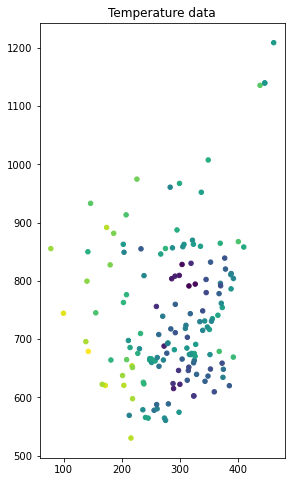

In [4]:
temperatures = gl.Db.createFromNF(temp_nf)
temperatures.setLocator("January_temp", gl.ELoc.Z)
temperatures.setLocator("Elevation",gl.ELoc.F)
iuid = temperatures.addSelection(np.invert(np.isnan(temperatures["J*"])),"sel")
temperatures.display()
ax = temperatures.plot("January_temp")
ax.decoration(title="Temperature data")

The output file is a grid (called **grid**). It contains an active selection (**inshore**) as well as the elevation over the field (called **Elevation**). Note that this variable is assigned the locator **f** (external drift).


Data Base Grid Characteristics

Data Base Summary
-----------------
File is organized as a regular grid
Space dimension              = 2
Number of Columns            = 4
Maximum Number of UIDs       = 4
Total number of samples      = 11097
Number of active samples     = 3092

Grid characteristics:
---------------------
Origin :     65.000   535.000
Mesh   :      4.938     4.963
Number :         81       137

Variables
---------
Column = 0 - Name = Longitude - Locator = x1
Column = 1 - Name = Latitude - Locator = x2
Column = 2 - Name = Elevation - Locator = f1
Column = 3 - Name = inshore - Locator = sel
 

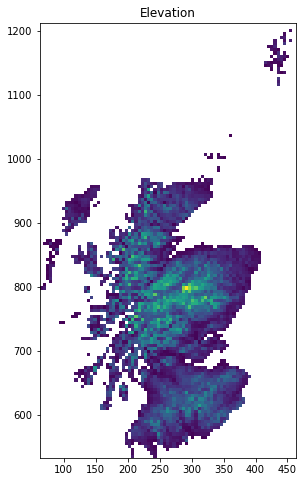

In [5]:
fileNF='Scotland_Elevations.NF'
if flagInternetAvailable:
    elev_nf, head = urllib.request.urlretrieve('https://soft.minesparis.psl.eu/gstlearn/data/Scotland/'+fileNF,'./'+fileNF)
else:
    elev_nf='./'+fileNF
    

grid = gl.DbGrid.createFromNF(elev_nf)
grid.display()
ax = grid.plot("Elevation")
ax.decoration(title="Elevation")

Calculate the omni-directional variogram of the temperature for 18 lags of 25.


Variogram characteristics
Number of variable(s)       = 1
Number of direction(s)      = 1
Space dimension             = 2
Variance-Covariance Matrix     1.020

Direction #1
------------
Number of lags              = 18
Direction coefficients      =      1.000     0.000
Direction angles (degrees)  =      0.000     0.000
Tolerance on direction      =     90.000 (degrees)
Calculation lag             =     25.000
Tolerance on distance       =     50.000 (Percent of the lag value)

For variable 1
      Rank    Npairs  Distance     Value
         0    78.000     7.681     0.137
         1   512.000    26.905     0.376
         2   915.000    50.556     0.614
         3  1135.000    74.820     0.855
         4  1285.000   100.070     0.935
         5  1190.000   124.927     1.050
         6  1117.000   149.550     1.099
         7  1004.000   175.060     1.218
         8   924.000   199.603     1.175
         9   769.000   224.493     1.502
        10   594.000   249.105     1.377
        11

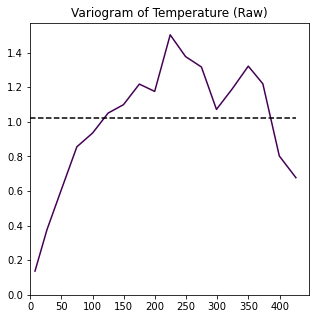

In [6]:
vparam = gl.VarioParam.createOmniDirection(npas=18, dpas=25)
vario = gl.Vario(vparam,temperatures)
vario.compute()
vario.display()
ax = gp.variogram(vario)
ax.decoration(title="Variogram of Temperature (Raw)")

We calculate the variogram (using the same calculation parameters) based on the residuals after a trend has been removed. This trend is considered as a linear combinaison of the external drift information.


Variogram characteristics
Number of variable(s)       = 1
Number of direction(s)      = 1
Space dimension             = 2
Variance-Covariance Matrix     0.363

Direction #1
------------
Number of lags              = 18
Direction coefficients      =      1.000     0.000
Direction angles (degrees)  =      0.000     0.000
Tolerance on direction      =     90.000 (degrees)
Calculation lag             =     25.000
Tolerance on distance       =     50.000 (Percent of the lag value)

For variable 1
      Rank    Npairs  Distance     Value
         0    78.000     7.681     0.102
         1   512.000    26.905     0.163
         2   915.000    50.556     0.211
         3  1135.000    74.820     0.264
         4  1285.000   100.070     0.265
         5  1190.000   124.927     0.321
         6  1117.000   149.550     0.363
         7  1004.000   175.060     0.444
         8   924.000   199.603     0.466
         9   769.000   224.493     0.547
        10   594.000   249.105     0.561
        11

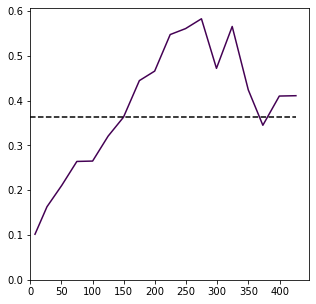

In [7]:
vparam = gl.VarioParam.createOmniDirection(npas=18, dpas=25)
vario = gl.Vario(vparam,temperatures)
md = gl.Model()
md.setDriftIRF(order=0, nfex=1)
vario.compute(model=md)
vario.display()
ax = gp.variogram(vario)

Fit the variogram of residuals in a model having drifts. Some constraints have been added during the fitting step.


Model characteristics
Space dimension              = 2
Number of variable(s)        = 1
Number of basic structure(s) = 2
Number of drift function(s)  = 2
Number of drift equation(s)  = 2

Covariance Part
---------------
Nugget Effect
- Sill         =      0.100
K-Bessel (Third Parameter = 1)
- Sill         =      0.420
- Range        =    282.586
- Theo. Range  =     81.575
Total Sill     =      0.520

Drift Part
----------
Universality Condition
External Drift - Rank=0
 

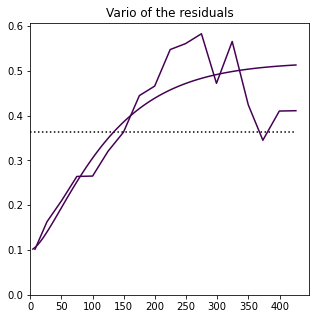

In [8]:
model = md

structs = [gl.ECov.NUGGET,gl.ECov.BESSEL_K]

consNug = gl.ConsItem.define(gl.EConsElem.SILL,0, type = gl.EConsType.UPPER,value = 0.1)

cons1P  = gl.ConsItem.define(gl.EConsElem.PARAM,1, type = gl.EConsType.EQUAL,value = 1)
cons1Rm = gl.ConsItem.define(gl.EConsElem.RANGE,1, type = gl.EConsType.LOWER,value = 100)
cons1RM = gl.ConsItem.define(gl.EConsElem.RANGE,1, type = gl.EConsType.UPPER,value = 350)

a = gl.Constraints()
a.addItem(consNug)
a.addItem(cons1P)
a.addItem(cons1Rm)
a.addItem(cons1RM)

err = model.fit(vario,structs,constraints=a)
model.display()
ax = gp.varmod(vario,model)
ax.decoration(title="Vario of the residuals")

Derive the parameter of a Global Trend (composed of the Elevation as a drift function) using the SPDE formalism.

In [9]:
spde = gl.SPDE(model,grid,temperatures,gl.ESPDECalcMode.KRIGING)
coeffs = spde.getCoeffs()
print("Trend coefficients:", coeffs)

Trend coefficients: [ 3.96977286 -0.00659747]


Represent the scatter plot of the Temperature given the Elevation and add the Global Trend (calculated beforehand)

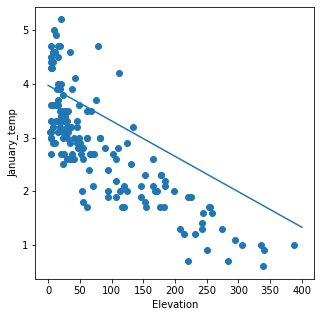

In [10]:
ax = gp.correlation(temperatures, namex="Elevation", namey="*temp", asPoint=True)
if len(coeffs)>1:
    plt.plot([0,400], [coeffs[0],coeffs[0]+coeffs[1]*400])

We perform the Estimation in the SPDE framework (considering the Elevation as the Global Trend)

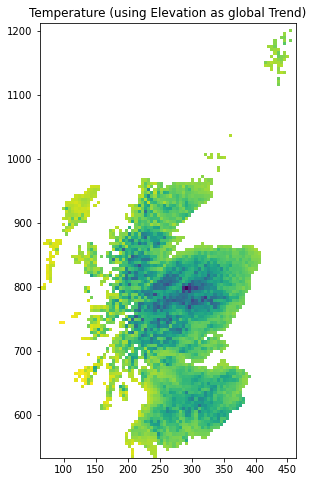

In [11]:
err = gl.krigingSPDE(temperatures, grid, model)
ax = grid.plot(useSel=True)
ax.decoration(title="Temperature (using Elevation as global Trend)")

We also perform the Estimation by Kriging (using Elevation as External Drift). This estimation is performed in Unique Neighborhood.

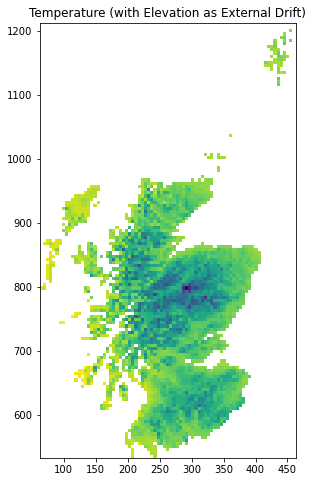

In [12]:
neighU = gl.NeighUnique.create();
gl.kriging(temperatures, grid, model, neighU);
ax = grid.plot(useSel=True)
ax.decoration(title="Temperature (with Elevation as External Drift)")

Comparing both estimates

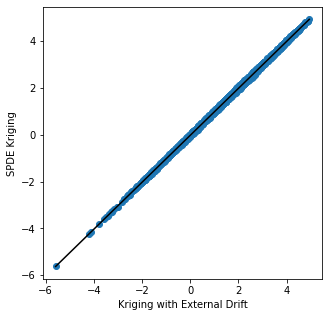

In [13]:
ax = gp.correlation(grid,namex="*estim",namey="*SPDE.*",asPoint=True, diagLine=True)
ax.decoration(xlabel="Kriging with External Drift", ylabel="SPDE Kriging")